## LCM Model:

W ---> l <---- U ----> Y <---- Phi and l --> L

U is the latent process that generates both Ls and Ys here Ls are 0s and 1s and Y are gaussian processes

here also we introduce S trials for each Y. To accomodate these we fold up Y's in vectorized form
#### Now, $Y \in R^{S \times CN}, u \in R^{S \times PN }$ and ${ \bar{\phi} }$ is a block diagonal of size CN X PN with CXP matrix ${\phi}$ on diagonals. Also $W \in R^{1 \times PN}$ 

###  $Y= u * \bar{\phi}^T + \sigma^2I$
###  $W= b + u * W^T + s^2I$
####  L = -1 if l < $\mu$ L = +1 otherwise 

here b is the bias and s denotes the noise in label generation process


##### Also, $u \in GP(0,\bar{K})$ where $\bar{K}$ is also a blaock diagonal of size PN x PN with covariance kernels ${K_p \in R ^{N \times N}}$ for each  gaussian process on diagonals.

In [1]:
### necessary Imports
import numpy as np
import pylab as pb
import scipy as sc
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Phi
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]


<matplotlib.colorbar.Colorbar instance at 0x7f6cc8dc3c20>

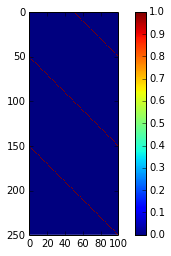

In [49]:
### Data Generation Process
S = 10
P = 2
C = 3
N = 50
s2 = 0.5
x = np.linspace(0,N-1,N)
#phi = np.random.normal(loc=0,scale=1,size=(C,P))
phi = np.array([[0,  1],
                [ 1, 0],
                [0 , 1],
                [ 1 , 0],
                [0 ,1]])
phiBar = np.matrix(np.kron(phi,np.eye(N)))
print "Phi\n",phi
plt.imshow(phiBar,interpolation='none')
plt.colorbar()

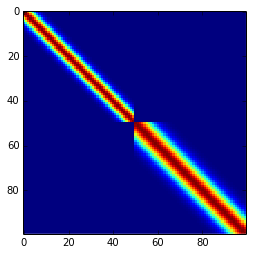

In [50]:
Kp = list()
for p in range(P):
    kenrel = GPy.kern.ExpQuad(1,lengthscale=3+2*p)
    Kp.append(kenrel.K(x.reshape(N,1))+np.eye(N)*0.0001)
#K.append(Kernel.generateKernel(Kernel.linear,x,x,a=0.001))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2))
Kbar = sc.linalg.block_diag(*Kp)
plt.imshow(Kbar,interpolation='none')

In [51]:
def guessLabel(l,mu=0):
    if l < mu:
        return -1
    else:
        return 1
    

Concatenated Latent Gaussian Processes:


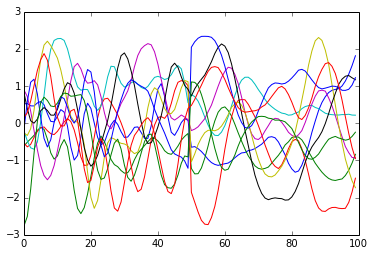

In [52]:
B = np.ones(S)*0.3
W = np.random.rand(P*N)
uBar = np.matrix(np.ones((S,N*P)))
l = np.zeros(S)
L = np.zeros(S)
for s in range(S):
    u = list()
    for p in range(P):
        u.append(np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=Kp[p]))
    us = np.hstack(u)
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    L[s] = guessLabel(l[s])
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uBar.T)

Generated Data:


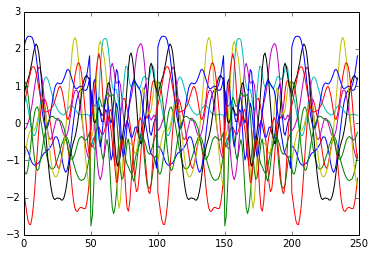

In [53]:
YBar = uBar * phiBar.T
print "Generated Data:"
i=plt.plot(YBar.T)

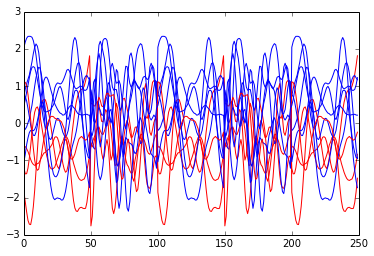

In [98]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
        else:
            plt.plot(YBar[s].T,c='b')
plotLabel(YBar,L,S)

### Inference: 

#### Initializations:

Concatenated Latent Gaussian Processes:
(200, 200) (10, 200, 1)


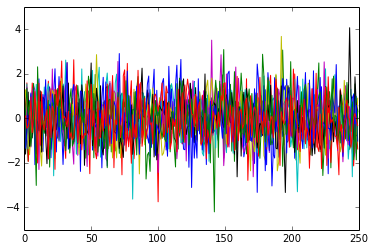

In [72]:
## get random inducing point
## Intialization for variational inference
P=5
noOfInductions = int(N*0.8)
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
nBar = np.concatenate([c*N+n for c in range(C)])
NBar = np.concatenate([c*N+x for c in range(C)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
ls = [2,2,2,2,2]
for i in range(P):
    kenrel = GPy.kern.ExpQuad(1,lengthscale=ls[i])
    Knn.append(kenrel.K(n.reshape(noOfInductions,1))+np.eye(noOfInductions)*0.0)
    KNn.append(kenrel.K(x.reshape(N,1), n.reshape(noOfInductions,1)))
    KNN.append(kenrel.K(x.reshape(N,1))+np.eye(N)*0.00)
    KnnInv.append(np.linalg.inv(Knn[i]))
Kpnn = np.matrix(sc.linalg.block_diag(*Knn))
KpNn = np.matrix(sc.linalg.block_diag(*KNn))
KpnnInv = np.matrix(sc.linalg.block_diag(*KnnInv))
KpNN = np.matrix(sc.linalg.block_diag(*KNN))
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
phiHatExpBar = np.kron(phiHatExp,np.eye(N))
phiHatVar = np.eye(P)
# Generate a guess for B
BHatMean = 0
BHatV = 1
BHatExp = np.mat(np.random.normal(loc=BHatMean,scale=BHatV,size=(1,S)))
# Generate a guess for W
WHatMean = 0
WHatV = 1
WHatExp = np.mat(np.random.normal(loc=BHatMean,scale=BHatV,size=(1,P*N)))
#Generate samples for latent
uHatMeansBar = np.random.normal(loc=0,scale=1,size=(S,noOfInductions*P,1))
uHatVsBar = np.eye(noOfInductions*P)
uExpBar = np.random.normal(loc=0,scale=1,size=(S,N*P))
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uExpBar.T)
print uHatVsBar.shape,uHatMeansBar.shape
## Generate Sample for latent labels
lHat = (uExpBar * WHatExp.T) + BHatExp.T
## Get initial label guess
LHat = [guessLabel(lHat[s]) for s in range(S)]

In [93]:
lHat

matrix([[  3.54046773],
        [-12.46187097],
        [ 33.99690967],
        [ -9.23538951],
        [  1.22887485],
        [-26.2009047 ],
        [-11.70748528],
        [  2.22245002],
        [  9.10100653],
        [  0.92006552]])

In [94]:
l

array([ -4.05415875, -41.53156145, -39.23187971,  35.55109495,
        16.93027085,   2.17663068,   8.83470523,  37.10993738,
       -22.39942722,  12.69988745])

In [95]:
L

array([-1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.])

In [96]:
LHat

[1, -1, 1, -1, 1, -1, -1, 1, 1, 1]